In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
df = pd.read_stata('data/ml_data.dta')

In [2]:
# Preprocessing

# No. of women in the household
df['a_women'] = (df['Gender'] == 'Female').astype(int)
women_by_hh = df.groupby('Common_ID')['a_women'].sum()
women_by_hh.name = 't_a_women'
df = df.merge(women_by_hh, left_on='Common_ID', right_index=True)
df['t_add_women'] = df['t_a_women'] - 1
df.rename({
    't_child': 'total_children',
    't_a_women': 'total_women',
    't_add_women': 'total_additional_women'
}, axis=1, inplace=True)

# Encode employment status
def enc_usual_principal_activity(val):
    if val < 31:
        return 1
    if val == 31:
        return 2
    if val in [41, 51]:
        return 3
    if val > 81:
        return 0
    return -1
df['employment'] = df['usual_principal_activity__status'].map(enc_usual_principal_activity)



X = df[df['Age'] >= 15]
X[['paid_activity_time', 'unpaid_activity_time']] /= 60
# encode education as int
X['education_enc'] = X['education'].cat.codes

# (X, y)s of the four regressions

male_feats = ['total_children', 'total_women', 'education_enc', 'marital_status', 'employment', 'state']
female_feats = ['total_children', 'total_additional_women', 'education_enc', 'marital_status', 'employment', 'state']

male_X = X[X['Gender'] == 'Male']
female_X = X[X['Gender'] == 'Female']

male_X_paid, male_y_paid = male_X[male_feats], male_X['paid_activity_time']
female_X_paid, female_y_paid = female_X[female_feats], female_X['paid_activity_time']

male_X_unpaid, male_y_unpaid = male_X[male_feats], male_X['unpaid_activity_time']
female_X_unpaid, female_y_unpaid = female_X[female_feats], female_X['unpaid_activity_time']

/tmp/ipykernel_79752/1250869453.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['a_women'] = (df['Gender'] == 'Female').astype(int)
/tmp/ipykernel_79752/1250869453.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['t_add_women'] = df['t_a_women'] - 1
/tmp/ipykernel_79752/1250869453.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fra

0.5190568168840318


<Axes: >

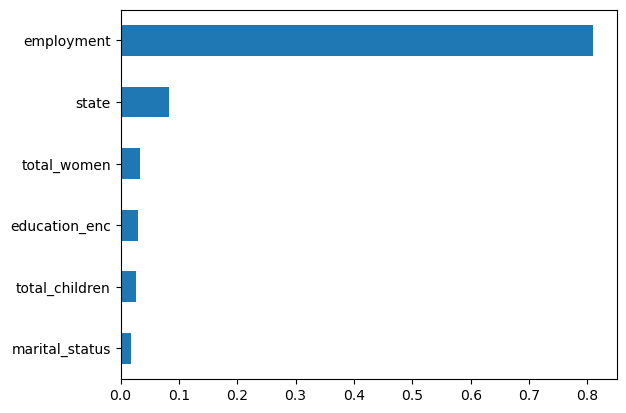

In [3]:
# Regressions
# 1. Male, paid

male_paid_tree = DecisionTreeRegressor()
print(male_paid_tree.fit(male_X_paid, male_y_paid).score(male_X_paid, male_y_paid))
pd.Series(male_paid_tree.feature_importances_, index=male_paid_tree.feature_names_in_).sort_values().plot(kind='barh')

0.2664647343480787


<Axes: >

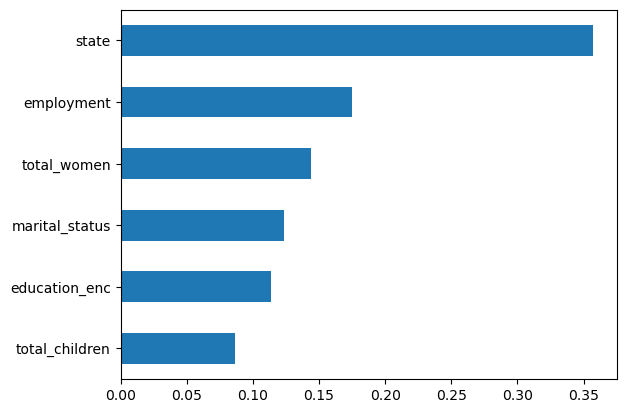

In [4]:
# Regressions
# 1. Male, unpaid

male_unpaid_tree = DecisionTreeRegressor()
print(male_unpaid_tree.fit(male_X_unpaid, male_y_unpaid).score(male_X_unpaid, male_y_unpaid))
pd.Series(male_unpaid_tree.feature_importances_, index=male_unpaid_tree.feature_names_in_).sort_values().plot(kind='barh')

0.6289702329096638


<Axes: >

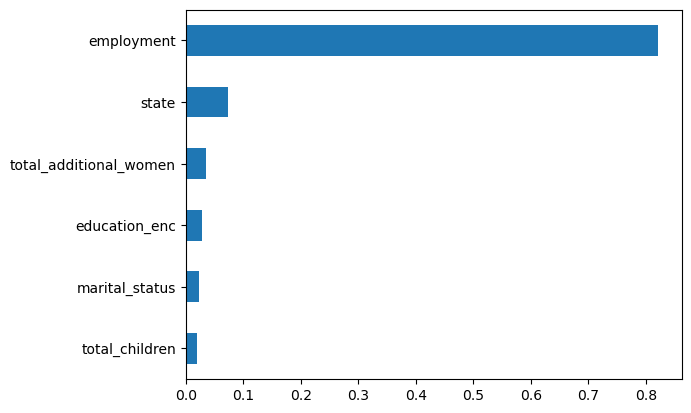

In [5]:
# Regressions
# 1. Female, paid

female_paid_tree = DecisionTreeRegressor()
print(female_paid_tree.fit(female_X_paid, female_y_paid).score(female_X_paid, female_y_paid))
pd.Series(female_paid_tree.feature_importances_, index=female_paid_tree.feature_names_in_).sort_values().plot(kind='barh')

0.49480574362619256


<Axes: >

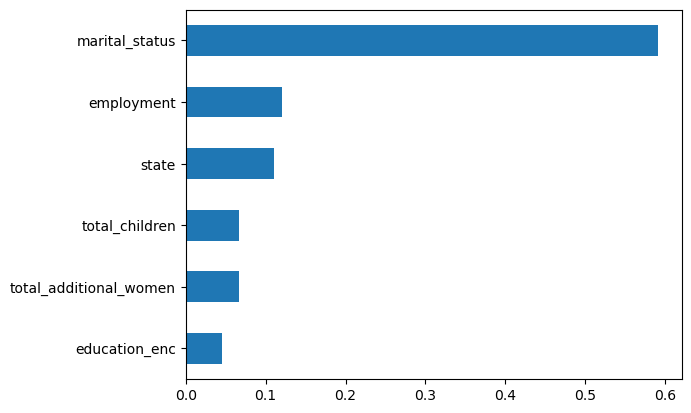

In [6]:
# Regressions
# 1. Female, unpaid

female_unpaid_tree = DecisionTreeRegressor()
print(female_unpaid_tree.fit(female_X_unpaid, female_y_unpaid).score(female_X_unpaid, female_y_unpaid))
pd.Series(female_unpaid_tree.feature_importances_, index=female_unpaid_tree.feature_names_in_).sort_values().plot(kind='barh')

In [12]:
xtest = female_X_unpaid[female_y_unpaid == 0]

In [18]:
graph = female_unpaid_tree.decision_path(xtest)

In [14]:
female_unpaid_tree.tree_.node_count

28965

In [16]:
x1 = xtest.iloc[0].values

In [17]:
x1

array([ 0.,  0.,  2.,  1.,  0., 33.])

In [20]:
graph = female_unpaid_tree.decision_path([x1])

/home/jaidevd/conda/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


In [23]:
nodes = graph.toarray().ravel()

In [28]:
female_unpaid_tree.apply(x1.reshape(1, -1))

/home/jaidevd/conda/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


array([6353])

In [37]:
X_test = xtest.iloc[:1].values
clf = female_unpaid_tree
node_indicator = clf.decision_path(X_test)
leaf_id = clf.apply(X_test)

sample_id = 0
# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
node_index = node_indicator.indices[
    node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
]

print("Rules used to predict sample {id}:\n".format(id=sample_id))
for node_id in node_index:
    # continue to the next node if it is a leaf node
    if leaf_id[sample_id] == node_id:
        continue

    # check if value of the split feature for sample 0 is below threshold
    if X_test[sample_id, clf.tree_.feature[node_id]] <= clf.tree_.threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print(
        "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
        "{inequality} {threshold})".format(
            node=node_id,
            sample=sample_id,
            feature=clf.tree_.feature[node_id],
            value=X_test[sample_id, clf.tree_.feature[node_id]],
            inequality=threshold_sign,
            threshold=clf.tree_.threshold[node_id],
        )
    )

Rules used to predict sample 0:

decision node 0 : (X_test[0, 3] = 1.0) <= 1.5)
decision node 1 : (X_test[0, 5] = 33.0) > 26.5)
decision node 5345 : (X_test[0, 5] = 33.0) > 29.5)
decision node 6137 : (X_test[0, 4] = 0.0) > -0.5)
decision node 6259 : (X_test[0, 1] = 0.0) <= 1.5)
decision node 6260 : (X_test[0, 0] = 0.0) <= 2.5)
decision node 6261 : (X_test[0, 2] = 2.0) > 0.5)
decision node 6305 : (X_test[0, 0] = 0.0) <= 1.5)
decision node 6306 : (X_test[0, 4] = 0.0) <= 2.5)
decision node 6307 : (X_test[0, 4] = 0.0) <= 1.5)
decision node 6308 : (X_test[0, 4] = 0.0) <= 0.5)
decision node 6309 : (X_test[0, 2] = 2.0) <= 3.5)
decision node 6310 : (X_test[0, 5] = 33.0) > 32.5)
decision node 6346 : (X_test[0, 1] = 0.0) <= 0.5)
decision node 6347 : (X_test[0, 0] = 0.0) <= 0.5)
decision node 6348 : (X_test[0, 5] = 33.0) <= 35.5)
decision node 6349 : (X_test[0, 5] = 33.0) <= 33.5)
decision node 6350 : (X_test[0, 2] = 2.0) > 1.5)
decision node 6352 : (X_test[0, 2] = 2.0) <= 2.5)


/home/jaidevd/conda/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/jaidevd/conda/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


In [43]:
graph.indptr[0:1]

array([0], dtype=int32)

In [41]:
sample_id

0

In [42]:
sample_id + 1

1